# Fine-tuning Classifier LLM


In [14]:
# setup - load packages
import pandas as pd
from datasets import Dataset, load_dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from typing import Union, Mapping, List, Dict, Any
import evaluate
from tqdm import tqdm
import zipfile
import os


# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 13

cpu


In [9]:
classifier_data = pd.read_csv("../data/classifier_data_A.csv")
# converting to huggingface dataset format
data = Dataset.from_pandas(classifier_data)
# splitting into train, test and validation sets
# party data
raw_dataset = data.shuffle(seed=seed)

# 70% train, 15% test, 15% validation data
split = raw_dataset.train_test_split(test_size=0.3, seed=seed)
train_data = split["train"]
text_and_val_data = split["test"]
split = text_and_val_data.train_test_split(test_size=0.5, seed=seed)
test_data = split["train"]
val_data = split["test"]

print(f"Training samples party: {len(train_data)}")
print(f"Test samples party: {len(test_data)}")
print(f"Validation samples party: {len(val_data)}")



# data balancing??


Training samples party: 25281
Test samples party: 5418
Validation samples party: 5418


In [4]:
from transformers import AutoTokenizer
from datasets import load_dataset
from typing import Union
from typing import Mapping

In [10]:
WINDOW_LENGTH = 512
STRIDE = 256

In [11]:
# Load Tokenizer
model_name = "bert-base-german-cased"
num_labels = 6
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=WINDOW_LENGTH
)


In [12]:
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']
label2id = {label: i for i, label in enumerate(sorted(label_names))}
id2label = {i: label for label, i in label2id.items()}

In [25]:
def sliding_window_tokenize(batch):
    texts = batch["speech_text"]
    labels = batch["label"]  # ensure this is a flat list of ints

    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
    )

    # Assign each overflow window the correct label
    tokenized["labels"] = [label2id[labels[i]] for i in tokenized["overflow_to_sample_mapping"]]

    return tokenized


In [61]:
from datasets import Dataset

# Beispiel: Kürzung auf 2000 Beispiele
tokenized_dataset = train_data.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data.column_names
)

Map:   0%|          | 0/25281 [00:00<?, ? examples/s]

In [11]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


In [62]:
print(tokenized_dataset[0]["labels"])  # sollte ein einzelner `int` sein, z. B. 3
print(type(tokenized_dataset[0]["labels"]))  # <class 'int'>

1
<class 'int'>


In [63]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate


model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-german-cased",
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset.train_test_split(test_size=0.1)["train"],
    eval_dataset=tokenized_dataset.train_test_split(test_size=0.1)["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-2164122264.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.801400,0.594890,0.766977,0.767719
2,0.475200,0.302924,0.894042,0.886039
3,0.256300,0.171712,0.950701,0.949711


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=24303, training_loss=0.6086807753261517, metrics={'train_runtime': 6199.6484, 'train_samples_per_second': 31.36, 'train_steps_per_second': 3.92, 'total_flos': 5.115694103145677e+16, 'train_loss': 0.6086807753261517, 'epoch': 3.0})

In [ ]:
trainer.save_model("./bert_german_speech_classifier_fulldata")

In [66]:
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset

# model und tokenizer müssen schon geladen sein
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"]  # falls du wahren Wert mitgeben willst
        })

    return results


In [67]:
results = predict_proba_for_dataset(val_data)


  0%|          | 0/5418 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 5418/5418 [02:25<00:00, 37.23it/s]


In [68]:
from typing import List, Dict
import numpy as np

def add_predicted_labels(results: List[Dict], label_names: List[str]) -> List[Dict]:
    for item in results:
        probs = item["probs"]
        pred_idx = int(np.argmax(probs))
        item["prediction_label"] = label_names[pred_idx]
    return results

In [69]:
results = add_predicted_labels(results, sorted(label_names))

In [70]:
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig("confusion_slidingwindow_fulldata.png")
    plt.show()


    return metrics_summary




In [71]:
results_df = pd.DataFrame(results)

Model: bert-base-german-cased
  Accuracy: 0.804171280915467
  Balanced Accuracy: 0.7888836881077682
  Precision: 0.8154652639277679
  Recall: 0.7888836881077682
  F1-score: 0.7993156386294643
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.97      0.90      0.93       776
     CDU/CSU       0.81      0.85      0.83      1402
         FDP       0.78      0.67      0.72       713
       GRÜNE       0.76      0.63      0.69       712
       LINKE       0.85      0.82      0.83       581
         SPD       0.73      0.86      0.79      1234

    accuracy                           0.80      5418
   macro avg       0.82      0.79      0.80      5418
weighted avg       0.81      0.80      0.80      5418



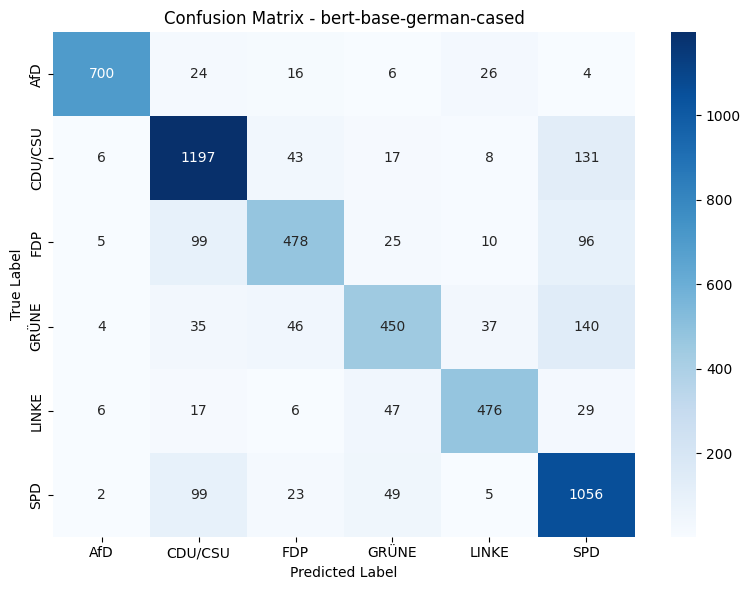

{'bert-base-german-cased': {'acc': 0.804171280915467,
  'bal_acc': np.float64(0.7888836881077682),
  'precision': 0.8154652639277679,
  'recall': 0.7888836881077682,
  'f1': 0.7993156386294643}}

<Figure size 640x480 with 0 Axes>

In [73]:
get_metrics(results_df['label'],results_df['prediction_label'])

In [75]:
results_df

,probs,label,prediction_label
0,"[0.00017410353757441044, 0.0001726595364743843...",LINKE,LINKE
1,"[0.0001470728311687708, 0.48318710923194885, 0...",CDU/CSU,CDU/CSU
2,"[0.00018254116002935916, 0.7668286561965942, 0...",CDU/CSU,CDU/CSU
3,"[0.000144667734275572, 0.3643619418144226, 0.0...",SPD,SPD
4,"[7.819286838639528e-05, 7.324050966417417e-05,...",LINKE,LINKE
...,...,...,...
5413,"[6.503691838588566e-05, 0.002560372930020094, ...",SPD,SPD
5414,"[0.0004209448234178126, 0.08983976393938065, 0...",LINKE,LINKE
5415,"[0.00042603033944033086, 0.0006034793332219124...",SPD,SPD
5416,"[0.0001148649025708437, 0.006084399297833443, ...",SPD,GRÜNE


In [74]:
results_df.to_csv("results_slidingwindow_fulldata.csv")

#### reload model

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Replace with your actual number of labels if needed
model_rl = AutoModelForSequenceClassification.from_pretrained("../data/windowmodel")
tokenizer_rl = AutoTokenizer.from_pretrained("../data/windowmodel")


c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tokenizer_rl

BertTokenizerFast(name_or_path='../data/windowmodel', vocab_size=30000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [17]:
# model und tokenizer müssen schon geladen sein
model_rl.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer_rl(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model_rl.device)
        attention_mask = tokenized["attention_mask"].to(model_rl.device)

        with torch.no_grad():
            outputs = model_rl(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"]  # falls du wahren Wert mitgeben willst
        })

    for item in results:
      probs = item["probs"]
      pred_idx = int(np.argmax(probs))
      item["prediction_label"] = label_names[pred_idx]
    return results


In [18]:
results_test = predict_proba_for_dataset(test_data, sorted(label_names))

  0%|          | 13/5418 [00:18<2:08:56,  1.43s/it]


KeyboardInterrupt: 